In [1]:
!pip install numpy==1.26.4
!pip install pycocotools==2.0.7
!pip install opencv-python==4.10.0.84
!pip install scikit-image==0.24.0
!pip install torch==2.2.2
!pip install torchvision==0.17.2
!pip install scikit-learn==1.5.1

In [2]:
import json
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from collections import Counter
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from skimage import io


# Constants and Hyperparameters
JSON_FILE = './dataset/custom-data/result.json'
ROOT_DIR = './dataset/custom-data'
NUM_EPOCHS = 20
BATCH_SIZE = 4
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4

# Transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CocoFormatDataset(Dataset):
    def __init__(self, json_file, root_dir, transform=None, required_annotations=8):
        with open(json_file, 'r') as f:
            self.coco_data = json.load(f)

        # Filter images by the number of annotations
        image_id_to_anns = Counter(ann['image_id'] for ann in self.coco_data['annotations'])
        valid_image_ids = {id for id, count in image_id_to_anns.items() if count == required_annotations}

        self.images = [img for img in self.coco_data['images'] if img['id'] in valid_image_ids]
        self.annotations = [ann for ann in self.coco_data['annotations'] if ann['image_id'] in valid_image_ids]
        self.root_dir = root_dir
        self.transform = transform
        self.cat_id_to_label = {cat['id']: idx for idx, cat in enumerate(self.coco_data['categories'])}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')

        ann_ids = [ann for ann in self.annotations if ann['image_id'] == img_info['id']]
        labels = torch.zeros(len(self.cat_id_to_label), dtype=torch.float32)
        categories = []

        for ann in ann_ids:
            cat_id = ann['category_id']
            label_index = self.cat_id_to_label[cat_id]
            labels[label_index] = 1
            for cat in self.coco_data['categories']:
                if cat['id'] == cat_id:
                    category_name = cat['name']
                    categories.append(category_name)
                    break

        if self.transform:
            image = self.transform(image)

        # print(f"Fetching image_id: {img_info['id']}, file_name: {img_info['file_name']}")
        # print(f"Identified Categories: {sorted(categories)}")
        # print(f"Labels: {labels.numpy()}, Total Labels: {torch.sum(labels)}")

        if len(categories) != 8:
            print(f"Warning: Expected 8 categories for image_id {img_info['id']}, got {len(categories)}. Skipping.")
            return None

        return image, labels


def prepare_dataset(json_file, root_dir, train_transform, test_transform):
    full_dataset = CocoFormatDataset(json_file=json_file, root_dir=root_dir, transform=train_transform)
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    test_dataset.dataset.transform = test_transform
    return train_dataset, test_dataset

def get_data_loaders(train_dataset, test_dataset, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

def initialize_model(output_size):
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, output_size)
    return model

def train_model(model, train_loader, num_epochs, learning_rate, weight_decay):
    writer = SummaryWriter()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if (i + 1) % 10 == 0:
                writer.add_scalar('Training Loss', running_loss / 10, epoch * len(train_loader) + i)
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss / 10:.4f}')
                running_loss = 0.0
    writer.close()

def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            predictions = torch.sigmoid(outputs) > 0.5
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
    
    # Converting to numpy arrays for evaluation
    y_true = np.array(y_true).reshape(-1)
    y_pred = np.array(y_pred).reshape(-1)
    
    # Calculate metrics
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    
    return accuracy, precision, recall, f1

def visualize_image_annotations(coco_json, image_id, base_dir):
    coco = COCO(coco_json)

    # Load the image
    img = coco.loadImgs(image_id)[0]
    image_path = os.path.join(base_dir, img['file_name'])
    I = io.imread(image_path)

    # Load and display instance annotations
    plt.imshow(I); plt.axis('off')
    annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    anns = coco.loadAnns(annIds)
    coco.showAnns(anns)

    # Print the classes
    classes = [coco.cats[ann['category_id']]['name'] for ann in anns]
    print(f'Classes: {classes}')

    plt.show()
    
def save_model(model, path="model.pth"):
    """
    Save the trained model to a file.
    """
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def load_model(path="model.pth", output_size=0):
    """
    Load a model from a file for inference.
    """
    model = initialize_model(output_size)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

def run_inference(model, image_path, transform):
    """
    Run inference on a single image and return the predicted labels.
    """
    image = Image.open(image_path).convert('RGB')
    if transform:
        image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        outputs = model(image)
        predictions = torch.sigmoid(outputs) > 0.5
    return predictions.numpy()


def get_top_n_predictions(predictions, categories, n=8):
    """
    Select the top N predictions based on the model's output scores.

    Parameters:
    - predictions: The raw output scores from the model.
    - categories: The list of category names corresponding to the model's outputs.
    - n: The number of top predictions to return.

    Returns:
    - A list of the top N predicted category names.
    """
    # Squeeze predictions to remove any unnecessary dimensions
    predictions = predictions.squeeze()
    # Get the indices of the top N scores
    top_n_indices = np.argsort(predictions)[-n:]
    # Map these indices to their corresponding category names
    top_n_categories = [categories[i] for i in top_n_indices]
    
    return top_n_categories


def get_categories_from_json(json_file):
    """
    Extract category names from a COCO format JSON file.

    Parameters:
    - json_file: Path to the COCO format JSON file.

    Returns:
    - A list of category names.
    """
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    categories = {category['id']: category['name'] for category in data['categories']}
    # Sorting categories by ID to ensure they are in the correct order
    sorted_categories = [categories[cat_id] for cat_id in sorted(categories)]
    
    return sorted_categories

def select_top_predictions_per_group(predictions, categories, n=8):
    """
    Select the top prediction for each port/cable type, ensuring diverse category representation.

    Parameters:
    - predictions: The raw output scores from the model.
    - categories: The list of category names corresponding to the model's outputs.
    - n: The desired number of top predictions.

    Returns:
    - A list of the top predicted category names, respecting the port/cable groupings.
    """
    predictions = predictions.squeeze()
    # Initialize a dictionary to hold the top prediction per group
    top_predictions_per_group = {}
    
    for score, category in sorted(zip(predictions, categories), reverse=True):
        # Extract the base name (e.g., "LAN1", "WAN2") to group categories
        base_name = "_".join(category.split("_")[:-1])
        
        # Only add the top scoring prediction for each base name
        if base_name not in top_predictions_per_group:
            top_predictions_per_group[base_name] = category
            
        # Stop if we've reached the desired number of predictions
        if len(top_predictions_per_group) >= n:
            break
    
    # Extract and return the selected category names
    selected_categories = list(top_predictions_per_group.values())
    
    return selected_categories

def run_inference_raw_output(model, image_path, transform):
    image = Image.open(image_path).convert('RGB')
    if transform:
        image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        outputs = model(image)
    return torch.sigmoid(outputs).numpy()


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Classes: ['ConsolePort_Connected', 'WAN1_Port_NotConnected', 'WAN2_Port_Connected_NotLit', 'LAN1_Port_NotConnected', 'LAN2_Port_NotConnected', 'LAN3_Port_NotConnected', 'LAN4_Port_NotConnected', 'PowerCable_Connected']


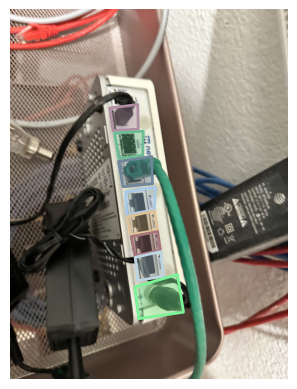

In [3]:
visualize_image_annotations(JSON_FILE, 35, ROOT_DIR)

In [4]:
categories = get_categories_from_json(JSON_FILE)
print(categories)

['ConsolePort_Connected', 'ConsolePort_NotConnected', 'LAN1_Port_Connected_Lit', 'LAN1_Port_Connected_NotLit', 'LAN1_Port_NotConnected', 'LAN2_Port_Connected_Lit', 'LAN2_Port_Connected_NotLit', 'LAN2_Port_NotConnected', 'LAN3_Port_Connected_Lit', 'LAN3_Port_Connected_NotLit', 'LAN3_Port_NotConnected', 'LAN4_Port_Connected_Lit', 'LAN4_Port_Connected_NotLit', 'LAN4_Port_NotConnected', 'PowerCable_Connected', 'PowerCable_NotConnected', 'WAN1_Port_Connected_Lit', 'WAN1_Port_Connected_NotLit', 'WAN1_Port_NotConnected', 'WAN2_Port_Connected_Lit', 'WAN2_Port_Connected_NotLit', 'WAN2_Port_NotConnected']


In [5]:
import numpy as np
print('Numpy version')
print(np.__version__)

train_dataset, test_dataset = prepare_dataset(JSON_FILE, ROOT_DIR, train_transform, test_transform)
train_loader, test_loader = get_data_loaders(train_dataset, test_dataset, BATCH_SIZE)
model = initialize_model(len(train_dataset.dataset.cat_id_to_label))

# Training
train_model(model, train_loader, NUM_EPOCHS, LEARNING_RATE, WEIGHT_DECAY)

# Evaluation
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Saving the model
save_model(model, "models/v1.pth")

print('Finished Training')


Numpy version
1.26.4


/Users/bpandey/Documents/workspace/aiml/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bpandey/Documents/workspace/aiml/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Step [10/20], Loss: 0.2677
Epoch [1/20], Step [20/20], Loss: 0.2244
Epoch [2/20], Step [10/20], Loss: 0.1769
Epoch [2/20], Step [20/20], Loss: 0.1156
Epoch [3/20], Step [10/20], Loss: 0.1285
Epoch [3/20], Step [20/20], Loss: 0.1470
Epoch [4/20], Step [10/20], Loss: 0.1450
Epoch [4/20], Step [20/20], Loss: 0.1227
Epoch [5/20], Step [10/20], Loss: 0.1320
Epoch [5/20], Step [20/20], Loss: 0.1548
Epoch [6/20], Step [10/20], Loss: 0.1475
Epoch [6/20], Step [20/20], Loss: 0.1173
Epoch [7/20], Step [10/20], Loss: 0.0865
Epoch [7/20], Step [20/20], Loss: 0.1049
Epoch [8/20], Step [10/20], Loss: 0.0951
Epoch [8/20], Step [20/20], Loss: 0.0728
Epoch [9/20], Step [10/20], Loss: 0.0778
Epoch [9/20], Step [20/20], Loss: 0.0901
Epoch [10/20], Step [10/20], Loss: 0.0831
Epoch [10/20], Step [20/20], Loss: 0.0883
Epoch [11/20], Step [10/20], Loss: 0.0972
Epoch [11/20], Step [20/20], Loss: 0.1028
Epoch [12/20], Step [10/20], Loss: 0.0945
Epoch [12/20], Step [20/20], Loss: 0.0680
Epoch [13/

In [6]:
inference_model = load_model("models/v1.pth", len(train_dataset.dataset.cat_id_to_label))

# Running inference on a new image
test_image_path = "./dataset/test-images/img-1.jpg"  # Replace with the path to your new image
predictions = run_inference(inference_model, test_image_path, test_transform)
print("Inference results:", predictions)

# Using the same 'model', 'image_path', and 'transform' as before
raw_predictions = run_inference_raw_output(inference_model, test_image_path, test_transform)
print("Raw predictions:", raw_predictions)

top_predicted_categories = select_top_predictions_per_group(raw_predictions, categories, n=8)
print("Diversely Predicted Categories:", ', '.join(top_predicted_categories))

/Users/bpandey/Documents/workspace/aiml/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bpandey/Documents/workspace/aiml/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inference results: [[ True False False  True False  True False False False False  True False
   True False  True False False False  True  True False False]]
Raw predictions: [[9.9914193e-01 8.0920820e-04 7.7580416e-04 6.1469084e-01 3.8343042e-01
  9.9925488e-01 3.8707610e-02 2.0388156e-04 9.3502359e-04 1.1098699e-03
  9.9917030e-01 4.7560069e-01 8.7577891e-01 7.9538561e-03 9.9891329e-01
  7.9505873e-04 6.0091051e-04 8.1419986e-04 9.9909616e-01 7.5781929e-01
  3.3643967e-01 2.8672809e-02]]
Diversely Predicted Categories: LAN2_Port_Connected_Lit, LAN3_Port_NotConnected, ConsolePort_Connected, WAN1_Port_NotConnected, PowerCable_Connected, LAN4_Port_Connected_NotLit, WAN2_Port_Connected_Lit, LAN1_Port_Connected_NotLit


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Classes: ['ConsolePort_Connected', 'WAN1_Port_NotConnected', 'WAN2_Port_Connected_Lit', 'LAN1_Port_NotConnected', 'LAN2_Port_Connected_Lit', 'LAN3_Port_NotConnected', 'LAN4_Port_NotConnected', 'PowerCable_Connected']


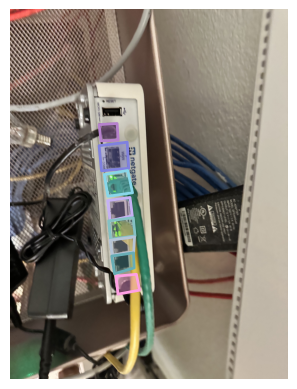

Inference results: [[ True False False False  True  True False False False False  True False
  False  True  True False False False  True  True False False]]
Raw predictions: [[9.9999964e-01 3.2094772e-07 5.3956614e-07 5.3287561e-09 1.0000000e+00
  9.9576664e-01 9.8404498e-06 6.2982799e-03 4.8006262e-07 5.0533197e-07
  9.9999952e-01 7.1973838e-05 3.3103675e-05 9.9998844e-01 9.9999928e-01
  3.2110387e-07 2.7357478e-07 3.9240692e-07 9.9999952e-01 9.4021821e-01
  2.0605946e-04 1.1113221e-01]]
Diversely Predicted Categories: LAN1_Port_NotConnected, ConsolePort_Connected, WAN1_Port_NotConnected, LAN3_Port_NotConnected, PowerCable_Connected, LAN4_Port_NotConnected, LAN2_Port_Connected_Lit, WAN2_Port_Connected_Lit


In [7]:
visualize_image_annotations(JSON_FILE, 54, ROOT_DIR)
test_image_path = "./dataset/custom-data/images/b7c832be-IMG_4900.jpg"  # Replace with the path to your new image
predictions = run_inference(inference_model, test_image_path, test_transform)
print("Inference results:", predictions)

# Using the same 'model', 'image_path', and 'transform' as before
raw_predictions = run_inference_raw_output(inference_model, test_image_path, test_transform)
print("Raw predictions:", raw_predictions)

top_predicted_categories = select_top_predictions_per_group(raw_predictions, categories, n=8)
print("Diversely Predicted Categories:", ', '.join(top_predicted_categories))

In [9]:
!pip install onnx==1.16.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 14.0 MB/s eta 0:00:0000:0100:01


In [10]:
import torch
import torch.onnx
from torchvision import models
import torch.nn as nn

output_size = len(train_dataset.dataset.cat_id_to_label)
print(output_size)

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, output_size)

# Load the trained weights
model.load_state_dict(torch.load("models/v1.pth"))
model.eval()

# Define the dummy input as per the input size of the model. Here, it is 3x224x224 (C, H, W).
dummy_input = torch.randn(1, 3, 224, 224)

# Specify the ONNX model path
onnx_model_path = "models/model_v1.onnx"

# Export the model to the ONNX format
torch.onnx.export(model, dummy_input, onnx_model_path, opset_version=11, input_names=['input'], output_names=['output'], dynamic_axes={'input' : {0 : 'batch_size'}, 'output' : {0 : 'batch_size'}})

print(f"Model has been converted to ONNX format and saved to {onnx_model_path}")


22


/Users/bpandey/Documents/workspace/aiml/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bpandey/Documents/workspace/aiml/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model has been converted to ONNX format and saved to models/model_v1.onnx


In [11]:
from torchvision import transforms
from PIL import Image
import json
import numpy as np

# Define the transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and transform the image
image_path = "./dataset/test-images/img-1.jpg"
payload_file_path = './dataset/test-images/request_payload.json'
image = Image.open(image_path).convert('RGB')
transformed_image = transform(image)

# Convert the transformed image to a list (or nested list if required by your model input format)
# Here, we assume the model expects the flattened list of normalized pixel values
image_data = transformed_image.numpy().flatten().tolist()

# Check the expected number of elements
if len(image_data) != 3*224*224:
    print("Error: The number of elements in 'image_data' does not match the expected input size.")
else:
    # Construct the JSON payload correctly without converting it to a string first
    payload = {
        "inputs": [{
            "name": "input",
            "shape": [1, 3, 224, 224],
            "datatype": "FP32",
            "data": image_data
        }]
    }

    # Write the JSON payload directly to the file
    with open(payload_file_path, 'w') as f:
        json.dump(payload, f)  # Note: using `dump` not `dumps`

    print(f"JSON payload is ready and saved to {payload_file_path}.")


JSON payload is ready and saved to ./dataset/test-images/request_payload.json.


In [14]:
!pip install requests==2.32.3

  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached idna-3.7-py3-none-any.whl.metadata (9.9 kB)
  Using cached urllib3-2.2.2-py3-none-any.whl.metadata (6.4 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.0/163.0 kB 2.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.4/121.4 kB 3.5 MB/s eta 0:00:00
Using cached idna-3.7-py3-none-any.whl (66 kB)
Using cached urllib3-2.2.2-py3-none-any.whl (121 kB)


In [19]:
import requests
import json
import os
import numpy as np
from urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(category=InsecureRequestWarning)

# Assuming TOKEN is set in your environment variables
token = os.getenv('TOKEN')

# URL of the OpenVINO model server REST API endpoint
url = os.getenv('MODEL_SERVER')

dataset_instance = CocoFormatDataset(JSON_FILE, ROOT_DIR, transform=None)
categories = dataset_instance.cat_id_to_label

# Path to the payload file
payload_file_path = './dataset/test-images/request_payload.json'

# Load the payload from the file
with open(payload_file_path, 'r') as f:
    payload = json.load(f)

# Headers for the request, including the authorization token
headers = {
    "Authorization": f"Bearer {token}",  # Use the actual token variable
    "Content-Type": "application/json"
}

# Send a request, skipping SSL certificate verification and including the authorization header
response = requests.post(url, json=payload, headers=headers, verify=False)

# Parse the response
if response.status_code == 200:
    predictions = response.json()
    print("Inference results:", predictions)
    
    # Extract raw predictions from the model's response
    raw_predictions = np.array(predictions['outputs'][0]['data'])  # Convert to numpy array if not already
    
    # Assuming categories is already correctly defined as a list of category names
    categories = get_categories_from_json(JSON_FILE)
    
    # Call select_top_predictions_per_group with the raw predictions and categories list
    top_predicted_categories = select_top_predictions_per_group(raw_predictions, categories, n=8)
    print("Diversely Predicted Categories:", ', '.join(top_predicted_categories))
else:
    print("Failed to get response, status code:", response.status_code, "\nReason:", response.text)



Inference results: {'model_name': 'router-detection__isvc-a4907ed515', 'model_version': '1', 'outputs': [{'name': 'output', 'datatype': 'FP32', 'shape': [1, 22], 'data': [9.071823, -8.916251, -6.486163, -4.0440097, 4.1139703, 7.247003, -9.081788, -8.305661, -8.958325, -8.988324, 9.122134, -3.2479231, -4.5926766, 2.4564378, 8.917142, -9.105866, -9.298585, -9.038394, 9.248299, 1.5314978, -3.2370124, -2.9561484]}]}
Diversely Predicted Categories: WAN1_Port_NotConnected, LAN3_Port_NotConnected, ConsolePort_Connected, PowerCable_Connected, LAN2_Port_Connected_Lit, LAN1_Port_NotConnected, LAN4_Port_NotConnected, WAN2_Port_Connected_Lit
